Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [73]:
from random import choices
import random
import lab9_lib
import tqdm
import numpy as np
import logging

from copy import deepcopy
from matplotlib import pyplot as plt
from collections import namedtuple
TERMINATION_SOUND = False

if TERMINATION_SOUND:
    from playsound import playsound

from tqdm import tqdm

In [87]:
PROBLEM_SIZE=1000

NUM_GENERATIONS = 10000
EPOCH_DURATION = 100

POPULATION_SIZE = 100
OFFSPRING_SIZE = 5

MUTATION_PROB = 0.3 #mutation or xover
#STRONG_MUTATION_PROB = 0.1 #strong mutation or mutation
XOVER_PROB = 0.7

SELF_UPDATE=False
MIGRANTS=True
MIGRATION_WAIT = 500
N_ISLANDS = 4
BOAT_SIZE = 10
COLORS = ['red','green','blue','violet']





In [75]:


MUT_STRENGTH = 1

def tournament(population, tournament_size=2):
    
    if isinstance(tournament_size,float): #usually instance of int -> skip
        small_size=int(tournament_size)
        big_size=small_size+1
        p_small = tournament_size-float(small_size)
        tournament_size = np.random.choice([small_size,big_size],p=[p_small,1-p_small])
   
    return max(random.choices(population, k=tournament_size), key=lambda i: i.fitness)


def toggle_mutation(g): #violate the rule of small changes but useful to start
    points = [random.choice([pos for pos in range(0,PROBLEM_SIZE)]) for _ in range(MUT_STRENGTH)]
    child = deepcopy(g)
    for point in points:
        child[point] = 1 - child[point] 
    return child

#classical x_over
#NOT USED
def one_cut_cross_over(g1, g2):
    cut = random.randint(0, PROBLEM_SIZE)
    return g1[:cut] + g2[cut:]

#NOT USED
def two_cut_cross_over(g1, g2):
    cut1 = random.randint(0, PROBLEM_SIZE)
    cut2 = random.randint(0, PROBLEM_SIZE)
    if cut2 < cut1:
        cut1,cut2 = cut2, cut1
    if random.random() < 0.5:
        return g1[:cut1] + g2[cut1:cut2] + g1[cut2:]
    else:
        return g2[:cut1] + g1[cut1:cut2] + g2[cut2:]

def uniform_cross_over(g1, g2):
    keep = choices([0,1],k=PROBLEM_SIZE)
    child = []
    for i,swap in enumerate(keep):
        if swap == 0:
            child.append(g1[i])
        else:
            child.append(g2[i])
    return child

#NOT USED
def uniform_two_cut_cross_over(p1,p2):
    if random.random()<0.2:
        return two_cut_cross_over(p1,p2)
    else:
        return uniform_cross_over(p1,p2)
    
#NOT USED
def voting_cross_over(g1, g2, g3):
    child = []
    for i in range(len(g1)):
        vote = g1[i]+g2[i]+g3[i]
        if vote>=2:
            child.append(1)
        else:
            child.append(0)
    
    return child

#permutation mutation

#NOT USED
def scramble_mutation(g):

    child = deepcopy(g)
    for i in range(MUT_STRENGTH):
        l1 = random.randint(0,len(g)-1)
        l2 = random.randint(0,len(g)-1)
        child[l1],child[l2]=child[l2],child[l1]

    return child

def insert_mutation(g): #can cost a lot

    child = deepcopy(g)
    for i in range(MUT_STRENGTH):
        l1 = random.randint(0,len(g)-2)
        l2 = random.randint(1,len(g)-1)
        if l1 > l2:
            l1,l2=l2,l1
        
        if l2 < len(g)-1:
            child = child[:l1] + [child[l2]] + child[l1:l2] + child[l2+1:]
        else:
            child = child[:l1] + [child[l2]] + child[l1:l2]

    return child
   
#NOT USED
LEN_INV_THRESHOLD = 4
def inversion_mutation(g): #strong mutation

    child = deepcopy(g)
    for i in range(MUT_STRENGTH):
        l1 = random.randint(0,len(g)-2)
        l2 = random.randint(1,len(g)-1)
        if l1 > l2:
            l1,l2=l2,l1
        while( abs(l1-l2) > LEN_INV_THRESHOLD):
            l1 = random.randint(0,len(g)-2)
            l2 = random.randint(1,len(g)-1)
            if l1 > l2:
                l1,l2=l2,l1
        
        
        new_child = child[0:l1]
        new_child += [child[i] for i in range (l2-1,l1-1,-1)]
        new_child += child[l2:]
    
    return child
        

def toggle_insert_mutation(g):
    if random.random() < 0.4:
        return toggle_mutation(g)
    else:
        return insert_mutation(g)
    
#permutation crossover

#NOT USED
def s1(sub_seq1,sub_seq2):
    return -sum([(sub_seq1[i]+sub_seq2[i])%2 for i in range(len(sub_seq1))])

def s2(sub_seq1,sub_seq2):
    return -abs(sum(sub_seq1)-sum(sub_seq2))

def s3(sub_seq1,sub_seq2):
    int_seq1 = sum([sub_seq1[i]*2**i for i in range(len(sub_seq1))])
    int_seq2 = sum([sub_seq2[i]*2**i for i in range(len(sub_seq2))])
    return -abs(int_seq1-int_seq2)

similarity = s1

def permutation_crossover(p1,p2): #skipped too complicated
    #p1 p2 are divided into 50 blocks
    #than a similarity is computed between each couple of block
    simV = []
    for i in range(50):
        for j in range(50):
            sij = similarity(p1[i*20:(i+1)*20],p2[j*20:(j+1)*20])
            simV.append((sij,i,j))
    
    simV.sort(key = lambda x: x[0])
    mapping_g1=[]
    mapping_g2=[]
    for _ in range(50):
        mapping_g1.append(0)
        mapping_g2.append(0)
    
    found=1
    for pair in simV:
        (_,i,j) = pair
        if (mapping_g1[i]==0) and (mapping_g2[j]==0):
            mapping_g1[i]=found
            mapping_g2[i]=found
            found+=1
        if found == len(mapping_g1):
            break # mapping is complete
    
#------

    
    
    



mutation = toggle_insert_mutation
cross_over = uniform_cross_over

initial population:10


Generation: 100%|██████████████████████████████████████████████████| 10000/10000 [17:49<00:00]


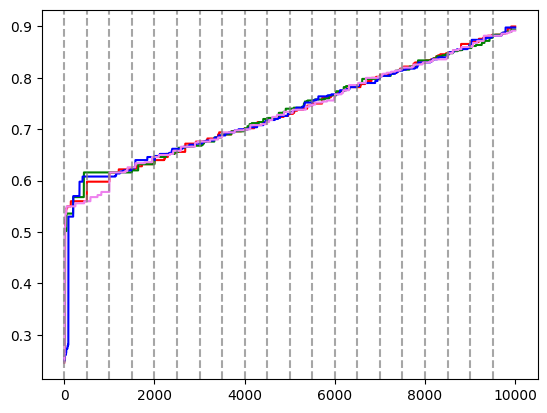

0.9
0.894
0.898
0.892
fitness calls:200010


In [88]:

#same as previous year code on Github/Squillero

Individual = namedtuple("Individual", ["genome", "fitness"])
#cross_over_types = [one_cut_cross_over,uniform_cross_over,two_cut_cross_over,uniform_two_cut_cross_over]

fitness = lab9_lib.make_problem(2)

if MIGRANTS:
    populationV = []
    population = []
    for n in range(10): #don't change initial population
        ind = choices([0, 1], k=PROBLEM_SIZE)
        population.append(Individual(ind, fitness(ind)))

    xV=[]
    yV=[]
    for i in range(N_ISLANDS):
        populationV.append(deepcopy(population))
        xV.append([])
        yV.append([])
else:
    population = []
    for n in range(10): #don't change initial population
        ind = choices([0, 1], k=PROBLEM_SIZE)
        population.append(Individual(ind, fitness(ind)))
    
    x=[] #generation
    y=[] #top_fitness
    n_improved=0

t_size = 2

print(f"initial population:{fitness.calls}")

#p_gen_op = np.array([STRONG_MUTATION_PROB,MUTATION_PROB,XOVER_PROB,1-(STRONG_MUTATION_PROB+MUTATION_PROB+XOVER_PROB)])
#p_gen_op = np.array([STRONG_MUTATION_PROB,MUTATION_PROB,XOVER_PROB])
p_gen_op = np.array([MUTATION_PROB,XOVER_PROB])

custom_bar_format = "{l_bar}{bar:50}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]"

progress_bar = tqdm(range(NUM_GENERATIONS),dynamic_ncols=True,desc="Generation",colour="green",total=NUM_GENERATIONS,mininterval=0.5,bar_format=custom_bar_format,ncols=100)

for g in progress_bar:
    
    if MIGRANTS:

        for island_number in range(N_ISLANDS):

            population = populationV[island_number]
            offspring = list()
                
            for i in range(OFFSPRING_SIZE):
                action = np.random.choice([0,1],p=p_gen_op) # keep it 0.3, 0.7 -> ideal

                if action == 0:
                    p = tournament(population,t_size)
                    o = mutation(p.genome)
                else:
                    p1 = tournament(population,t_size)
                    p2 = tournament(population,t_size)
                    o = cross_over(p1.genome, p2.genome)
                
                f = fitness(o)
                
                offspring.append(Individual(o, f))
            
            population += offspring
            #population = sorted(population, key=lambda i: np.random.choice([i.fitness,1.0],p=[0.99,0.01]), reverse=True)[:POPULATION_SIZE] #fitness hole
            population = sorted(population, key=lambda i: i.fitness, reverse=True)[:POPULATION_SIZE] 
            
            populationV[island_number]=deepcopy(population)

            # tweak probability 
            
            xV[island_number].append(g)
            yV[island_number].append(population[0].fitness)


            if(population[0].fitness == 1):
                print("ok")
                break
        
        if g%MIGRATION_WAIT == 0:
            if(len(population)==POPULATION_SIZE): #at start population size = 10 -> need first to grow
                #random_offset = random.randint(0,N_ISLANDS)
                for i in range(0,N_ISLANDS):
                    for j in range(i+1,N_ISLANDS):
                        migrants_from_i = random.sample([n for n in range(POPULATION_SIZE)], k = BOAT_SIZE)
                        migrants_from_j = random.sample([n for n in range(POPULATION_SIZE)], k = BOAT_SIZE)
                        
                        #rand_j = (j + random_offset)% N_ISLANDS
                        for m in range(BOAT_SIZE):
                            populationV[i][migrants_from_i[m]],populationV[j][migrants_from_j[m]]=populationV[j][migrants_from_j[m]],populationV[i][migrants_from_i[m]]

                    

        if(1.0 in [populationV[i][0].fitness for i in range(N_ISLANDS)]):
            break
            
    else:
        offspring = list()
            
        for i in range(OFFSPRING_SIZE):
            action = np.random.choice([0,1],p=p_gen_op) # keep it 0.3, 0.7 -> ideal

            if action == 0:
                p = tournament(population,t_size)
                o = mutation(p.genome)
            else:
                p1 = tournament(population,t_size)
                p2 = tournament(population,t_size)
                o = cross_over(p1.genome, p2.genome)
            
            f = fitness(o)
            
            offspring.append(Individual(o, f))
        
        n_improved += len([child for child in offspring if child.fitness > population[0].fitness])#self adapt mut_prob -> 1 out  of 5 rule

        
        population += offspring
        #population = sorted(population, key=lambda i: np.random.choice([i.fitness,1.0],p=[0.99,0.01]), reverse=True)[:POPULATION_SIZE] #fitness hole
        population = sorted(population, key=lambda i: i.fitness, reverse=True)[:POPULATION_SIZE] 

        # tweak probability 
        if SELF_UPDATE:
            if g%EPOCH_DURATION==0:
                #x.append(g)
                #y.append(0.5)
                
                
                if n_improved < EPOCH_DURATION*1/5*OFFSPRING_SIZE: #not really useful keep P_MUT around 0.3
                    t_size = 1.6 #original 1.7
                else:
                    t_size = 2.1 #original 2.0
                
                n_improved = 0

        x.append(g)
        y.append(population[0].fitness)

        if(population[0].fitness == 1):
            print("ok")
            break
    
    

if MIGRANTS:
    for island_number in range(N_ISLANDS):
        plt.plot(xV[island_number],yV[island_number],color=COLORS[island_number])
    [plt.axvline(x,linestyle='--', color='gray', alpha=0.7) for x in range(0,NUM_GENERATIONS,MIGRATION_WAIT)]

    plt.show()
    for island_number in range(N_ISLANDS):
        print(populationV[island_number][0].fitness)
    
else:
    plt.plot(x,y,color='red')
    [plt.axvline(x,linestyle='--', color='gray', alpha=0.7) for x in range(0,NUM_GENERATIONS,EPOCH_DURATION)]
    plt.show()

    print(population[0].fitness)

print(f"fitness calls:{fitness.calls}")

if TERMINATION_SOUND:
    playsound('\KSBGCBV-happy-fanfare.mp3')

#--> use TOGGLE,UNIFORM for problem 1

#--> SCRAMBLE 0.488, INSERT 0.544, INVERSION 0.256 limit len 10 0.2806, limit len 5 0.25, limit len 4 0.26 -> not_working

#diversity promotion

#tried fitness hole 0.966, 0.972, 0.966, 0.864, 0.756
#try also adding gaussian noise on fitness, sigma mutated like in SA -> can further explore, idea from Filippo Greco telegram public message
#tried w/o fitness hole 0.984,0.986,0.992, 0.982, 0.796, 0.992 --> better

#tried different tournament size for different improvement rate -> 10000 generations, 10 offspring, 100 population 
#1.7 for < 1/5 --> 0.644, 0.992, 0.948, 0.98, 0.92
#1.5 for < 1/5 --> 0.984, 0.594, 0.97, 0.998, 0.99
#2.0 for < 1/5 --> 0.928, 0.598, 0.972, 0.822, 0.966

# -> maybe is useful to lower t_size -> 1.7 produce good results
#instead of 1.7 / 2.0
#1.7 / 1.9 --> 0.986, 0.638, 0.944, 0.984, 0.98
#1.6 / 2.1 --> 0.982, 0.762, 0.984, 0.982, 0.988 --> seems the best tried option

#tried migrants
#1000: 0.592, 0.638..., 10000: 0.984 -> single island 
#1000: 0.644, 0.612, 0.612, 0.592 -> multi island alone
#5 migrants every 100 generations
#1000: 0.654, 0.662, 0.652, 0.646
#5 migrants every 50 generations
#1000: 0.66, 0.662, 0.662, 0.664 --> best for 1000 generations
#10 migrants every 50 generations
#1000: 0.652, 0.656, 0.65, 0.654
#10 migrants every 100 generations
#1000: 0.644, 0.644, 0.644, 0.646
#5 migrants every 20 generations
#1000: 0.642, 0.634, 0.642, 0.642
#10  migrants every 100 generations
#10000: 0.968, 0.968, 0.97, 0.972
#5 migrants every 500 generations
#10000: 0.966, 0.964, 0.962, 0.962
#5 migrants every 250 generations + shuffle order
#10000: 0.916, 0.918, 0.916, 0.914
#5 migrants every 500 generations + shuffle order
#10000: 0.944, 0.94, 0.942, 0.938
#10 migrants every 500 generations
#10000: 0.9, 0.894, 0.898, 0.892